In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Wed Dec  6 22:25:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from argparse import Namespace
from functools import lru_cache
from keras.layers import Embedding, LSTM, Dense, Dropout, TextVectorization
from keras.models import Sequential
import keras.callbacks
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tokenizers.processors import BertProcessing
from tokenizers import ByteLevelBPETokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
from datasets import load_dataset , Dataset , DatasetDict
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from typing import List
import datetime
import gensim
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import torch
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from gensim.models import Word2Vec, word2vec
from sklearn.base import clone
import gensim.downloader as api
from sklearn.preprocessing import normalize
from keras.utils import plot_model
nltk.download("stopwords")
sw_nltk = stopwords.words("english")
torch.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'2.1.0+cu118'

In [ ]:
def plot_histogram(df:pd.DataFrame)->None:
    df = df.copy()
    labels = list(df["label"].unique())
    try:
        for idx, i in enumerate(labels):
            df[i] = df["label"].apply(lambda x: 1 if i in x else 0)
        df.drop(
            [
                "label",
            ],
            axis=1,
            inplace=True,
        )
    except:
        pass
    temp_list = df.drop(["text"], axis=1).sum(axis=0).sort_values()
    print(temp_list)
    plt.bar(temp_list.index, temp_list)
    plt.title("Rozkład klas")
    plt.xlabel("Klasa")
    plt.ylabel("Liczba wystąpień")
    plt.xticks(rotation=60, ha="right")
    plt.show()

def create_raport(model_name, y_test, y_preds, training_duration,vector_name="")->None:
    conf_matix = confusion_matrix(y_test, y_preds)
    normalized_conf_matrix = conf_matix.astype('float') / conf_matix.sum(axis=1)[:, np.newaxis]
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=conf_matix,
        display_labels=emotion_list,
    )
    cm_norlamized_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=normalized_conf_matrix,
        display_labels=emotion_list,
    )

    cm_display.plot()
    plt.title('Macierz błędu')
    plt.xlabel('Przewidziana etykieta ')
    plt.ylabel('Etykieta')
    plt.show()

    cm_norlamized_display.plot()
    plt.title('Znormalizowana macierz błędu')
    plt.xlabel('Przewidziana etykieta ')
    plt.ylabel('Etykieta')
    plt.show()

    ACC = accuracy_score(y_test, y_preds)
    end = datetime.datetime.now()
    f1_score_micro = metrics.f1_score(
    y_test, y_preds, average="micro")
    f1_score_macro = metrics.f1_score(
    y_test, y_preds, average="macro")
    report = metrics.classification_report(y_test, y_preds , target_names=emotion_list)
    dict_report = metrics.classification_report(y_test, y_preds , target_names=emotion_list, output_dict=True)
    df = pd.DataFrame(dict_report).transpose()
    df.to_csv(f'{model_name}_{vector_name}.csv')
    print(report)
    print("Model:",model_name)
    if(vector_name):
        print("Vector input:",vector_name)
    print("trainning time:", f"{training_duration}s")
    print(f"Dokładność (accuracy)  = {ACC}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

def plot_model_history(accuracy, loss):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history["accuracy"])
    axs[0].set_title("Dokładność")
    axs[0].set_ylabel("Dokładność")
    axs[0].set_xlabel("Epoki")

    # Plot training & validation loss values
    axs[1].plot(history.history["loss"])
    axs[1].set_title("Funkcja kosztu")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoki")

    plt.show()

In [ ]:
dataset_name = "AdamCodd/emotion-balanced"

label2id = {"sadness": 0
            ,"joy": 1
            ,"love": 2
            ,"anger": 3
            ,"fear": 4
            ,"surprise": 5}
id2label = {"0": "sadness"
            ,"1": "joy"
            ,"2": "love"
            ,"3": "anger"
            ,"4": "fear"
            ,"5": "surprise"}
emotion_list = list(label2id.keys())

raw_dataset = load_dataset(dataset_name)
print(raw_dataset)
print(raw_dataset['train'].features)


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


In [ ]:
def hot_encode(df:pd.DataFrame):
    df["label"] = df["label"].map(lambda x: id2label[str(x)])
    one_hot_encoded = pd.get_dummies(df['label'])
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df
train = hot_encode(raw_dataset["train"].to_pandas())
test = hot_encode(raw_dataset["test"].to_pandas())
val = hot_encode(raw_dataset["validation"].to_pandas())


joy         2666
surprise    2666
anger       2667
fear        2667
love        2667
sadness     2667
dtype: int64


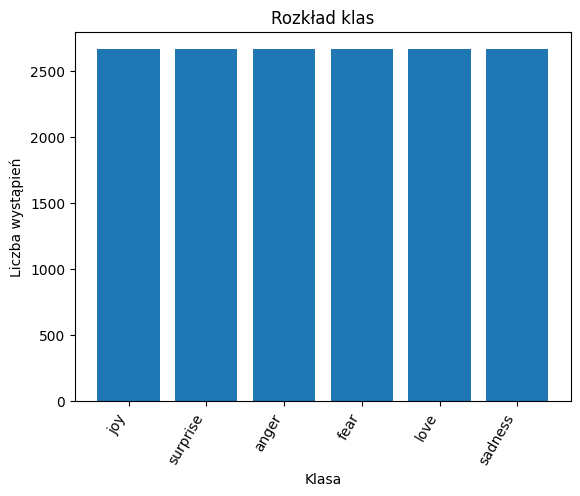

anger       333
love        333
sadness     333
surprise    333
fear        334
joy         334
dtype: int64


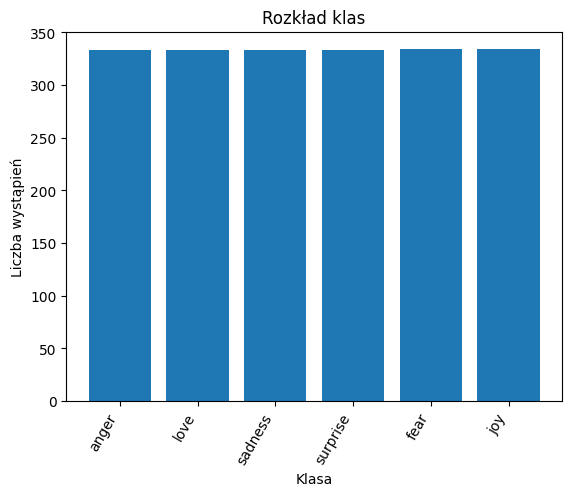

fear        333
joy         333
love        333
sadness     333
anger       334
surprise    334
dtype: int64


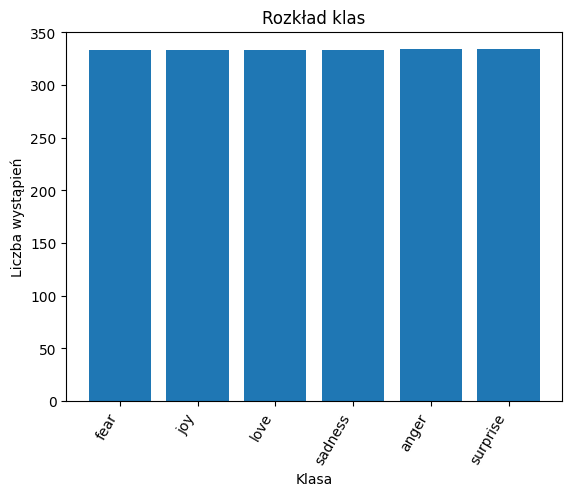

In [ ]:
plot_histogram(train)
plot_histogram(test)
plot_histogram(val)


In [ ]:
# df = pd.read_csv("./drive/MyDrive/air_ai.csv")
# emotion_list = list(df["Label"].unique())
# plot_histogram(df)
# df, emotion_list

# df = df.groupby("Label").sample(n=14972)
# df.reset_index(drop=True, inplace=True)
# plot_histogram(df)
# train, test = train_test_split(df, test_size=0.2)

In [ ]:
Y_train = np.asarray(train[train.columns[2:]])
Y_test = np.asarray(test[test.columns[2:]])
Y_val = np.asarray(val[val.columns[2:]])
Y_train, Y_test , Y_val

(array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        ...,
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0]], dtype=uint8),
 array([[1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0]], dtype=uint8),
 array([[0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0]], dtype=uint8))

In [ ]:
glove_gensim = api.load("glove-wiki-gigaword-100")
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    words_in_vocab = [word for word in words if word in model]
    if not words_in_vocab:
        return None
    embedding = sum(model[word] for word in words_in_vocab) / len(words_in_vocab)
    return embedding



[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
num_words = 10000
vector_size = 100
tokenizer = Tokenizer(num_words, lower=True)
corpus_train = train["text"]
corpus_train = corpus_train.apply(lambda line: gensim.utils.simple_preprocess((line)))
corpus_test = (
    train["text"].copy().apply(lambda line: gensim.utils.simple_preprocess((line)))
)
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(corpus_train)
X_train = tokenizer.texts_to_sequences(train["text"])
X_train_pad = pad_sequences(X_train, maxlen=300, padding="post")
X_test = tokenizer.texts_to_sequences(test["text"])
X_test_pad = pad_sequences(X_test, maxlen=300, padding="post")

gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero
        if word in glove_gensim:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 300, 200)          161600    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 400)          643200    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 300, 400)          0

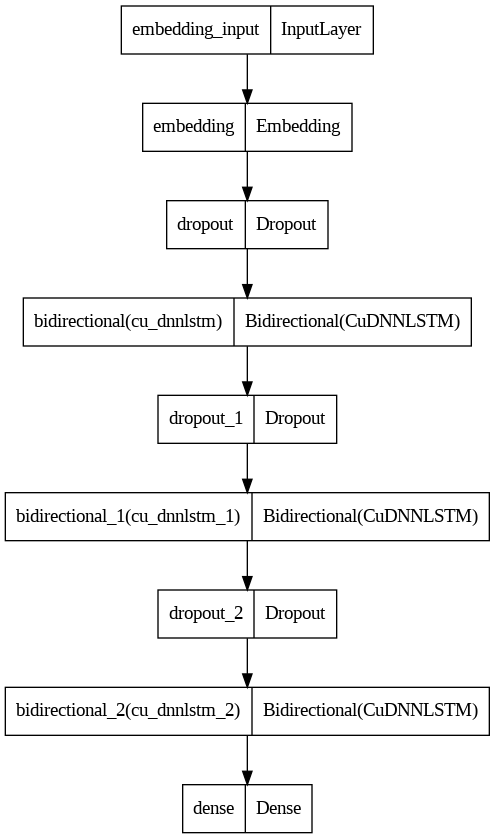

In [ ]:

model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = vector_size,
 input_length= X_train_pad.shape[1],
))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(len(emotion_list), activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')
model.summary()
plot_model(model)

In [ ]:
start = datetime.datetime.now()
history = model.fit(X_train_pad, Y_train, batch_size=32, epochs=10)
lstm_learning_time =  (datetime.datetime.now() - start).total_seconds()

Epoch 1/10
500/500 [==============================] - 63s 109ms/step - loss: 1.0223 - accuracy: 0.5824
Epoch 2/10
500/500 [==============================] - 41s 81ms/step - loss: 0.3611 - accuracy: 0.8929
Epoch 3/10
500/500 [==============================] - 40s 79ms/step - loss: 0.2430 - accuracy: 0.9231
Epoch 4/10
500/500 [==============================] - 39s 79ms/step - loss: 0.1763 - accuracy: 0.9381
Epoch 5/10
500/500 [==============================] - 39s 77ms/step - loss: 0.1273 - accuracy: 0.9544
Epoch 6/10
500/500 [==============================] - 39s 78ms/step - loss: 0.1011 - accuracy: 0.9641
Epoch 7/10
500/500 [==============================] - 38s 77ms/step - loss: 0.0875 - accuracy: 0.9693
Epoch 8/10
500/500 [==============================] - 38s 77ms/step - loss: 0.0855 - accuracy: 0.9697
Epoch 9/10
500/500 [==============================] - 38s 76ms/step - loss: 0.0712 - accuracy: 0.9743
Epoch 10/10
500/500 [==============================] - 38s 76ms/step - loss: 0.06

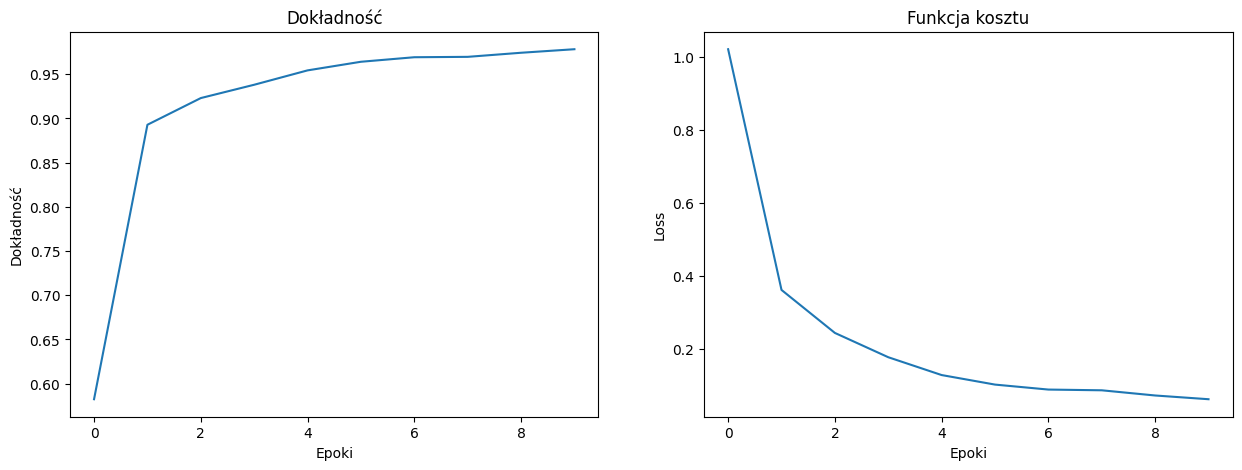

In [ ]:
plot_model_history(accuracy=history.history["accuracy"],loss=history.history["loss"] )

63/63 [==============================] - 3s 30ms/step


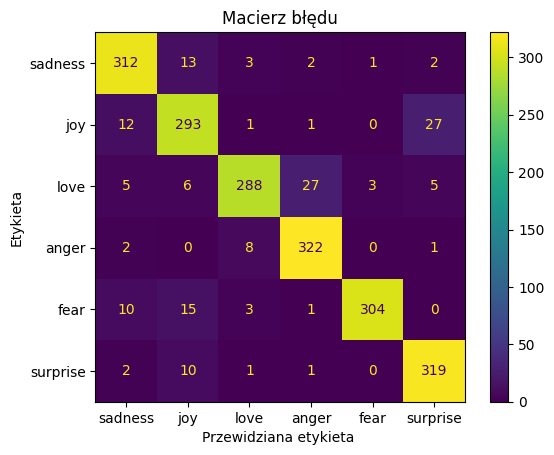

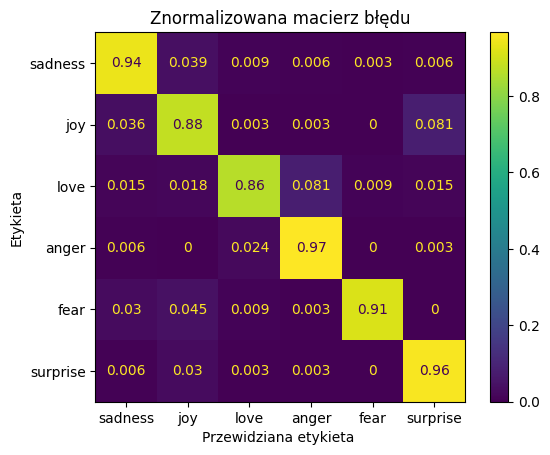

              precision    recall  f1-score   support

     sadness       0.91      0.94      0.92       333
         joy       0.87      0.88      0.87       334
        love       0.95      0.86      0.90       334
       anger       0.91      0.97      0.94       333
        fear       0.99      0.91      0.95       333
    surprise       0.90      0.96      0.93       333

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Model: Bidirectional LSTM
Vector input: Kerasa vectorizer
trainning time: 413.078192s
Dokładność (accuracy)  = 0.919
F1 Score (Micro) = 0.919
F1 Score (Macro) = 0.9189706672264872


In [ ]:
X_test_LSTM = model.predict(X_test_pad)
lstm_predictions = np.array(X_test_LSTM) >= 0.51
create_raport("Bidirectional LSTM", Y_test.argmax(axis=1), lstm_predictions.argmax(axis=1), lstm_learning_time,vector_name="Kerasa vectorizer")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 dropout_3 (Dropout)         (None, 300, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 300, 200)          161600    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 300, 400)          643200    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 300, 400)         

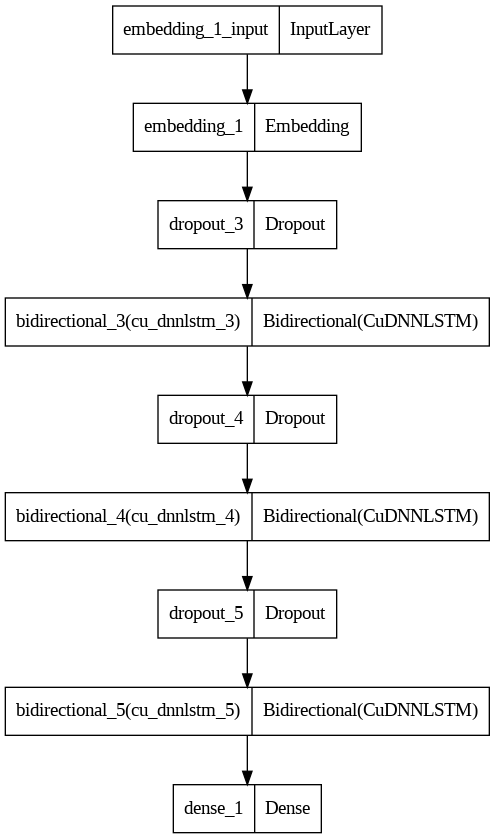

In [ ]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False
))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(len(emotion_list), activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

model.summary()
plot_model(model)

Epoch 1/10
500/500 [==============================] - 42s 75ms/step - loss: 1.2295 - accuracy: 0.5145
Epoch 2/10
500/500 [==============================] - 37s 74ms/step - loss: 0.6305 - accuracy: 0.7771
Epoch 3/10
500/500 [==============================] - 37s 74ms/step - loss: 0.4277 - accuracy: 0.8509
Epoch 4/10
500/500 [==============================] - 37s 75ms/step - loss: 0.3198 - accuracy: 0.8854
Epoch 5/10
500/500 [==============================] - 37s 75ms/step - loss: 0.2581 - accuracy: 0.9045
Epoch 6/10
500/500 [==============================] - 37s 75ms/step - loss: 0.2167 - accuracy: 0.9204
Epoch 7/10
500/500 [==============================] - 37s 75ms/step - loss: 0.2018 - accuracy: 0.9257
Epoch 8/10
500/500 [==============================] - 37s 74ms/step - loss: 0.1818 - accuracy: 0.9293
Epoch 9/10
500/500 [==============================] - 37s 75ms/step - loss: 0.1723 - accuracy: 0.9340
Epoch 10/10
500/500 [==============================] - 37s 75ms/step - loss: 0.158

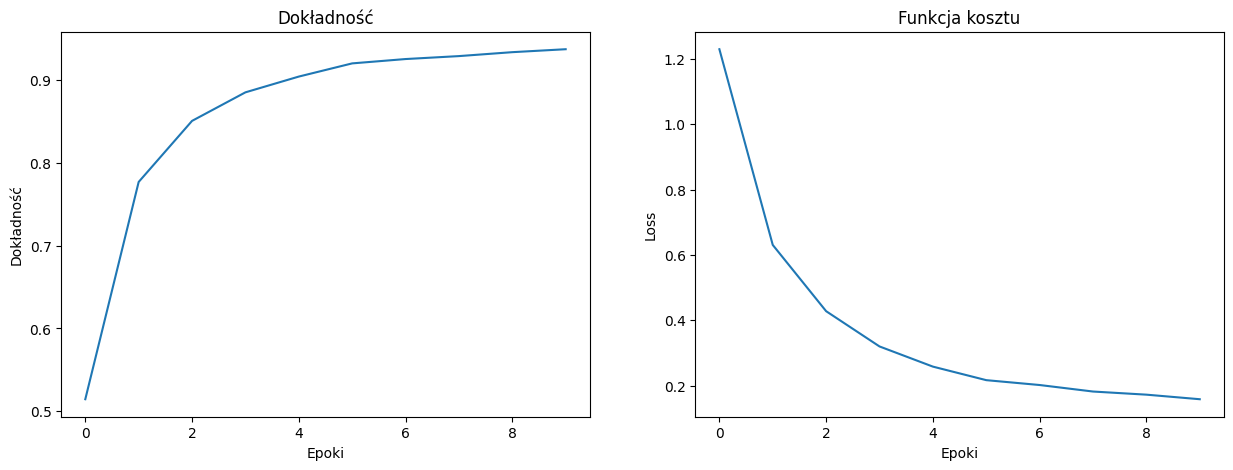

In [ ]:
start = datetime.datetime.now()
history = model.fit(X_train_pad, Y_train, batch_size=32, epochs=10)
lstm_learning_time = (datetime.datetime.now() - start).total_seconds()
plot_model_history(accuracy=history.history["accuracy"],loss=history.history["loss"] )

63/63 [==============================] - 2s 28ms/step


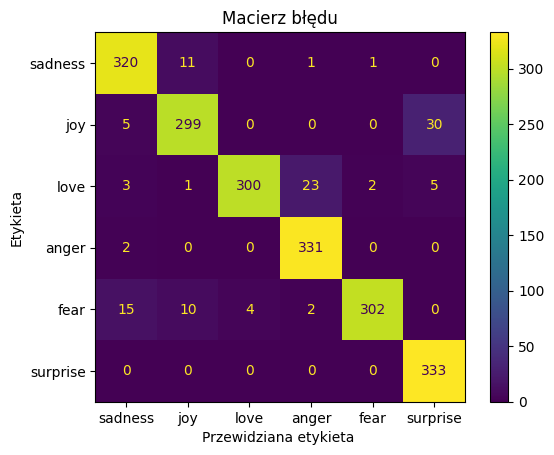

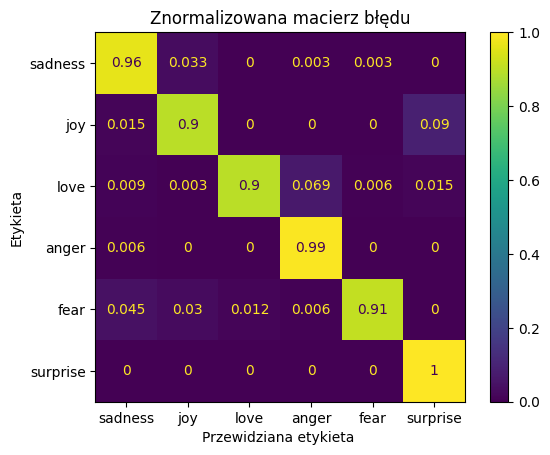

              precision    recall  f1-score   support

     sadness       0.93      0.96      0.94       333
         joy       0.93      0.90      0.91       334
        love       0.99      0.90      0.94       334
       anger       0.93      0.99      0.96       333
        fear       0.99      0.91      0.95       333
    surprise       0.90      1.00      0.95       333

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Model: Bidirectional LSTM
Vector input: Kerasa vectorizer with glove
trainning time: 378.010516s
Dokładność (accuracy)  = 0.9425
F1 Score (Micro) = 0.9425
F1 Score (Macro) = 0.9422614755918284


In [ ]:
X_test_LSTM = model.predict(X_test_pad)
lstm_predictions = np.array(X_test_LSTM) >= 0.51
create_raport("Bidirectional LSTM", Y_test.argmax(axis=1), lstm_predictions.argmax(axis=1), lstm_learning_time,vector_name="Kerasa vectorizer with glove")

In [ ]:
# W2VEC CORPUS TRAINED
corpus_train = train["text"]
corpus_train = corpus_train.apply(lambda line: gensim.utils.simple_preprocess((line)))
model_size = 300
model = Word2Vec(corpus_train,vector_size = model_size, sg=0, window=5, min_count=1, workers=4)
model.train(corpus_train, total_examples=len(corpus_train), epochs=50)
def word2vec_generator(texts, model, vector_size):
    dict_word2vec = {}
    for index, word_list in enumerate(texts):
        arr = np.array([0.0 for i in range(0, vector_size)])
        nb_word = 0
        for word in word_list:
            try:
                arr += model[word]
                nb_word = nb_word + 1
            except KeyError:
                continue
        if len(word_list) == 0:
            dict_word2vec[index] = arr
        else:
            dict_word2vec[index] = arr / nb_word
    df_word2vec = pd.DataFrame(dict_word2vec).T
    return df_word2vec
train_text = train["text"]
test_text = test["text"]
corpus_train_tokens = pd.Series(train_text).apply(
    lambda line: gensim.utils.simple_preprocess((line))
)
corpus_test_tokens = pd.Series(test_text).apply(
    lambda line: gensim.utils.simple_preprocess((line))
)
X_train_W2V = word2vec_generator(corpus_train_tokens, model.wv, model.vector_size)
X_test_W2V = word2vec_generator(corpus_test_tokens, model.wv, model.vector_size)
X_train_W2V = X_train_W2V.replace(np.nan, 0)
X_test_W2V = X_test_W2V.replace(np.nan, 0)
np.count_nonzero(np.isnan(X_train_W2V))

0

In [ ]:
# TFIDF
def tfidf(data,tfidf_vectorizer):
    train = tfidf_vectorizer.fit_transform(data)
    return train

tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_train_TFIDF= tfidf_vectorizer.fit_transform(train["text"])
X_test_TFIDF = tfidf_vectorizer.transform(test["text"])

## SVD
SVD = TruncatedSVD(n_components=500)
SVD.fit(X_train_TFIDF)
X_train_SVD = SVD.transform(X_train_TFIDF)
X_test_SVD = SVD.transform(X_test_TFIDF)

In [ ]:
X_train_TFIDF.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Number of estimators: 100


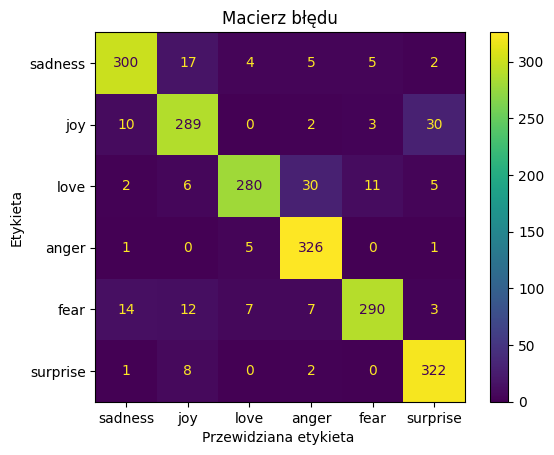

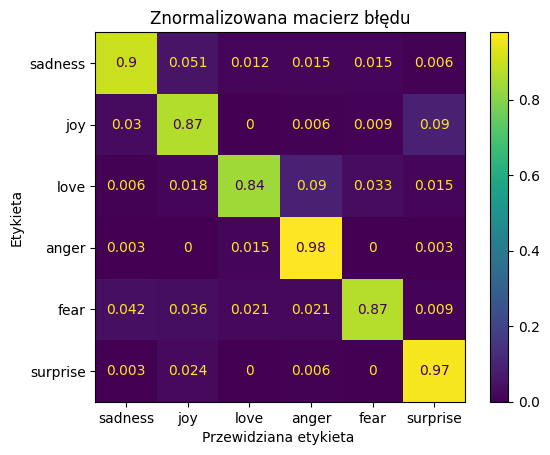

              precision    recall  f1-score   support

     sadness       0.91      0.90      0.91       333
         joy       0.87      0.87      0.87       334
        love       0.95      0.84      0.89       334
       anger       0.88      0.98      0.92       333
        fear       0.94      0.87      0.90       333
    surprise       0.89      0.97      0.93       333

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000

Model: Random forest classifier
Vector input: TF-IDF
trainning time: 20.685082s
Dokładność (accuracy)  = 0.9035
F1 Score (Micro) = 0.9035
F1 Score (Macro) = 0.9030015303070246
Number of estimators: 100


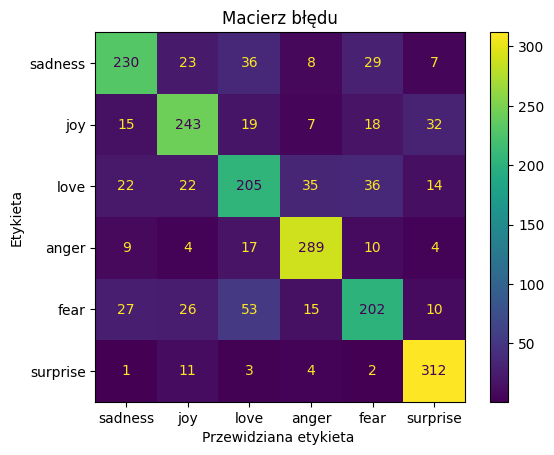

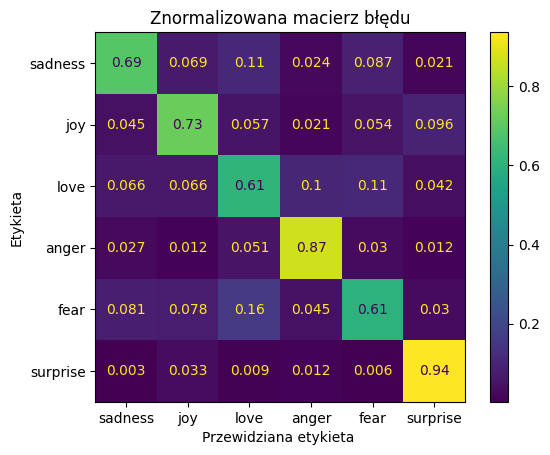

              precision    recall  f1-score   support

     sadness       0.76      0.69      0.72       333
         joy       0.74      0.73      0.73       334
        love       0.62      0.61      0.61       334
       anger       0.81      0.87      0.84       333
        fear       0.68      0.61      0.64       333
    surprise       0.82      0.94      0.88       333

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Model: Random forest classifier
Vector input: SVD
trainning time: 46.75931s
Dokładność (accuracy)  = 0.7405
F1 Score (Micro) = 0.7405
F1 Score (Macro) = 0.7373337595092337
Number of estimators: 100


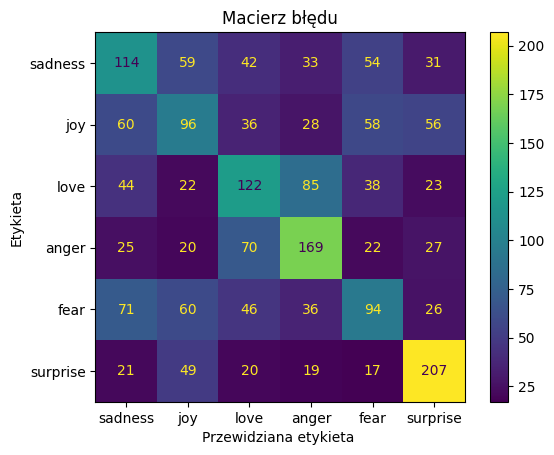

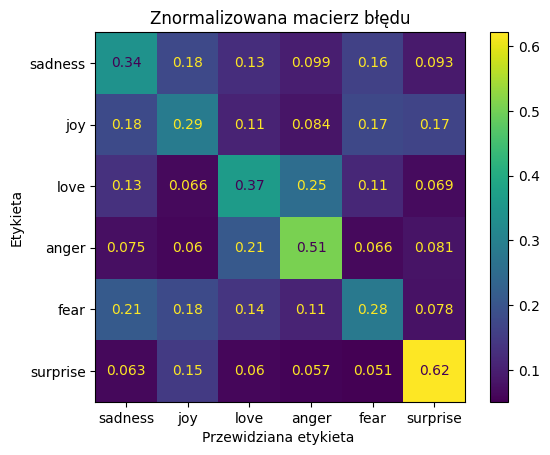

              precision    recall  f1-score   support

     sadness       0.34      0.34      0.34       333
         joy       0.31      0.29      0.30       334
        love       0.36      0.37      0.36       334
       anger       0.46      0.51      0.48       333
        fear       0.33      0.28      0.31       333
    surprise       0.56      0.62      0.59       333

    accuracy                           0.40      2000
   macro avg       0.39      0.40      0.40      2000
weighted avg       0.39      0.40      0.40      2000

Model: Random forest classifier
Vector input: W2VEC
trainning time: 27.985754s
Dokładność (accuracy)  = 0.401
F1 Score (Micro) = 0.401
F1 Score (Macro) = 0.39673209252824565


In [ ]:
from sklearn.tree import export_graphviz

def train_test_forest(model, X_train, y_train, X_test, y_test, vector_name):
    start = datetime.datetime.now()
    model = model.fit(X_train,y_train)
    training_duration = (datetime.datetime.now() - start).total_seconds()
    print("Number of estimators:",model.n_estimators)
    preds = model.predict(X_test)
    create_raport("Random forest classifier",y_test.argmax(axis=1),preds,training_duration,vector_name)

forest = RandomForestClassifier()

train_test_forest(
    model=  RandomForestClassifier(),
    X_train = X_train_TFIDF,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_TFIDF,
    y_test = Y_test,
    vector_name = "TF-IDF"
    )

train_test_forest(
    model=   RandomForestClassifier(),
    X_train = X_train_SVD,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_SVD,
    y_test = Y_test,
    vector_name = "SVD"
    )


train_test_forest(
    model=  RandomForestClassifier(),
    X_train = X_train_W2V,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_W2V,
    y_test = Y_test,
    vector_name = "W2VEC"
    )


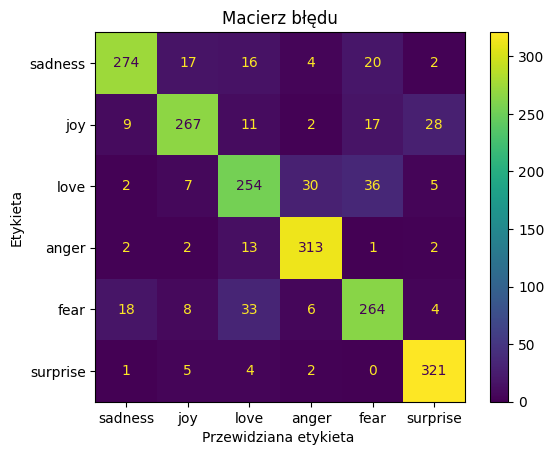

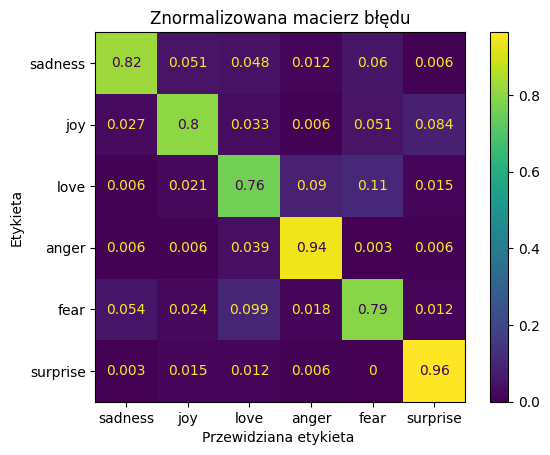

              precision    recall  f1-score   support

     sadness       0.90      0.82      0.86       333
         joy       0.87      0.80      0.83       334
        love       0.77      0.76      0.76       334
       anger       0.88      0.94      0.91       333
        fear       0.78      0.79      0.79       333
    surprise       0.89      0.96      0.92       333

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Model: Linear SVC
Vector input: SVD
trainning time: 4.106917s
Dokładność (accuracy)  = 0.8465
F1 Score (Micro) = 0.8465
F1 Score (Macro) = 0.8456245647823528


In [ ]:

def train_and_test_svc(model, X_train, y_train, X_test, y_test ,vector_name):
    start = datetime.datetime.now()
    model = model.fit(X_train, y_train)
    training_duration = (datetime.datetime.now() - start).total_seconds()
    preds = model.predict(X_test)
    y_test = y_test.argmax(axis=1)
    create_raport("Linear SVC",y_test,preds,training_duration,vector_name)

linear_svc =  LinearSVC()

train_and_test_svc(
    model=  LinearSVC(),
    X_train = X_train_SVD,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_SVD,
    y_test = Y_test,
    vector_name = "SVD"
    )

train_and_test_svc(
    model=  LinearSVC(),
    X_train = X_train_W2V,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_W2V,
    y_test = Y_test,
    vector_name = "W2VEC"
    )
train_and_test_svc(
    model= clone(linear_svc),
    X_train = X_train_TFIDF,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_TFIDF,
    y_test = Y_test,
    vector_name = "TF-IDF"
    )



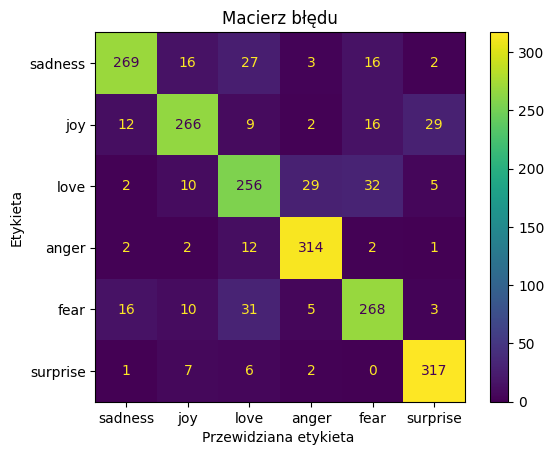

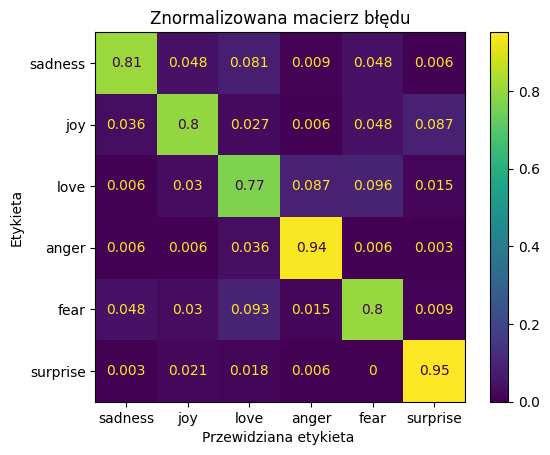

              precision    recall  f1-score   support

     sadness       0.89      0.81      0.85       333
         joy       0.86      0.80      0.82       334
        love       0.75      0.77      0.76       334
       anger       0.88      0.94      0.91       333
        fear       0.80      0.80      0.80       333
    surprise       0.89      0.95      0.92       333

    accuracy                           0.84      2000
   macro avg       0.85      0.85      0.84      2000
weighted avg       0.85      0.84      0.84      2000

Model: Logistic regression
Vector input: SVD
trainning time: 2.126027s
Dokładność (accuracy)  = 0.845
F1 Score (Micro) = 0.845
F1 Score (Macro) = 0.8442997154735349


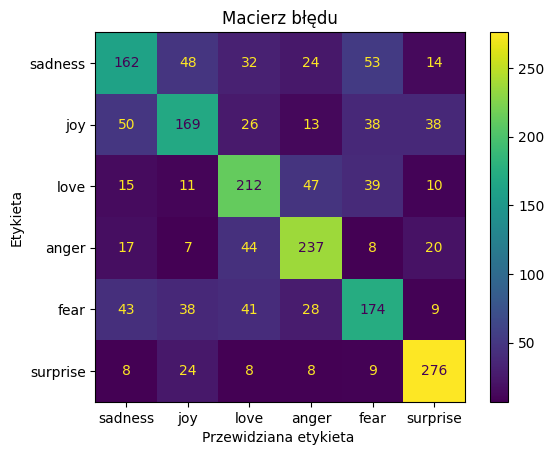

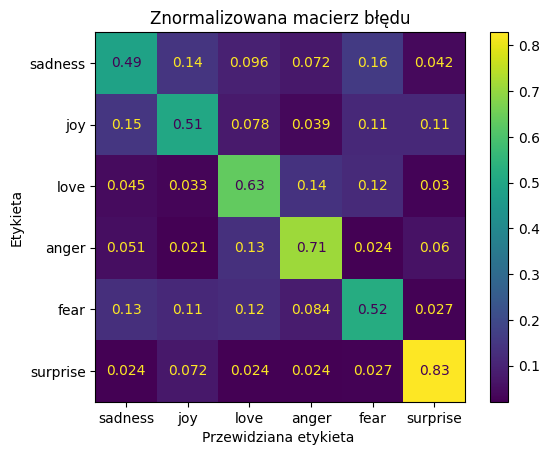

              precision    recall  f1-score   support

     sadness       0.55      0.49      0.52       333
         joy       0.57      0.51      0.54       334
        love       0.58      0.63      0.61       334
       anger       0.66      0.71      0.69       333
        fear       0.54      0.52      0.53       333
    surprise       0.75      0.83      0.79       333

    accuracy                           0.61      2000
   macro avg       0.61      0.62      0.61      2000
weighted avg       0.61      0.61      0.61      2000

Model: Logistic regression
Vector input: W2VEC
trainning time: 6.371469s
Dokładność (accuracy)  = 0.615
F1 Score (Micro) = 0.615
F1 Score (Macro) = 0.6112567787460735


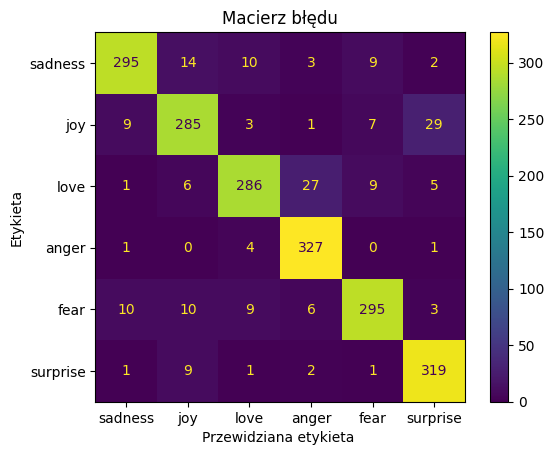

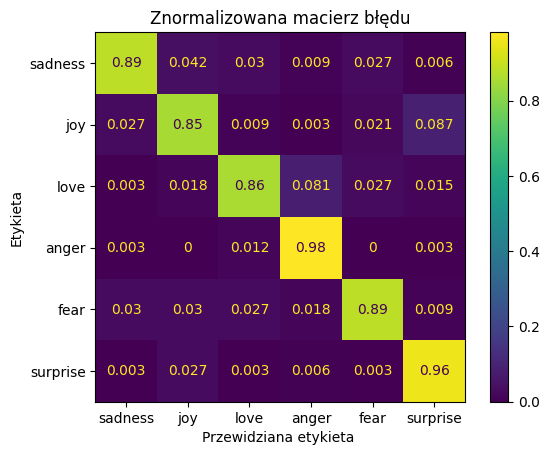

              precision    recall  f1-score   support

     sadness       0.93      0.89      0.91       333
         joy       0.88      0.85      0.87       334
        love       0.91      0.86      0.88       334
       anger       0.89      0.98      0.94       333
        fear       0.92      0.89      0.90       333
    surprise       0.89      0.96      0.92       333

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Model: Logistic regression
Vector input: TF-IDF
trainning time: 5.172342s
Dokładność (accuracy)  = 0.9035
F1 Score (Micro) = 0.9035
F1 Score (Macro) = 0.9029603975183215


In [ ]:
def train_and_test_logisticregression(model, X_train, y_train, X_test, y_test ,vector_name):
    start = datetime.datetime.now()
    model = model.fit(X_train, y_train)
    training_duration = (datetime.datetime.now() - start).total_seconds()
    preds = model.predict(X_test)
    y_test = y_test.argmax(axis=1)
    create_raport("Logistic regression",y_test,preds,training_duration,vector_name)

logistic_regression =  LogisticRegression(random_state = 0 , max_iter = 5000)

train_and_test_logisticregression(
    model=  logistic_regression,
    X_train = X_train_SVD,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_SVD,
    y_test = Y_test,
    vector_name = "SVD"
    )

train_and_test_logisticregression(
    model=  LogisticRegression(random_state = 0 , max_iter = 5000),
    X_train = X_train_W2V,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_W2V,
    y_test = Y_test,
    vector_name = "W2VEC"
    )
train_and_test_logisticregression(
    model= clone(logistic_regression),
    X_train = X_train_TFIDF,
    y_train = Y_train.argmax(axis=1),
    X_test = X_test_TFIDF,
    y_test = Y_test,
    vector_name = "TF-IDF"
    )

In [ ]:
dataset_name = "dair-ai/emotion"
model_ckpt = "bert-base-uncased" # bert-base-uncased
model_name = f"{model_ckpt}-finetuned-emotion"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt
                                    ,label2id = label2id
                                    ,id2label = id2label)

In [ ]:

def tokenize_function(example):
    return tokenizer(example['text'],truncation = True)
tokenized_bert_data = raw_dataset.map(tokenize_function,batched = True,batch_size = None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_bert_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,config = config).to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels
                  ,preds
                  ,average = 'weighted')
    acc = accuracy_score(labels
                         ,preds)
    return {'accuracy': acc, 'f1': f1}

In [ ]:
batch_size = 64
logging_steps = len(raw_dataset['train'])
training_args = TrainingArguments(output_dir = model_name
                                  ,seed = 42
                                  ,num_train_epochs = 5
                                  ,optim = 'adamw_torch'
                                  ,learning_rate = 5e-5
                                  ,weight_decay = 0
                                  ,evaluation_strategy = 'epoch'
                                  ,per_device_train_batch_size = batch_size
                                  ,per_device_eval_batch_size = batch_size
                                  ,disable_tqdm = False
                                  ,logging_strategy = 'steps'
                                  ,logging_steps = logging_steps
                                  ,log_level = 'error'
                                  ,report_to = 'none'
                                  ,push_to_hub = False
                                  )

In [ ]:
trainer = Trainer(model = model
                  ,tokenizer = tokenizer
                  ,data_collator = data_collator
                  ,args = training_args
                  ,compute_metrics = compute_metrics
                  ,train_dataset = tokenized_bert_data["train"]
                  ,eval_dataset = tokenized_bert_data["validation"])

In [ ]:
start = datetime.datetime.now()
trainer.train()
training_duration = (datetime.datetime.now() - start).total_seconds()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.216439,0.934000,0.933342
2,No log,0.178743,0.944000,0.943637
3,No log,0.158550,0.946500,0.946163
4,No log,0.186782,0.942500,0.942050
5,No log,0.191645,0.942500,0.942132


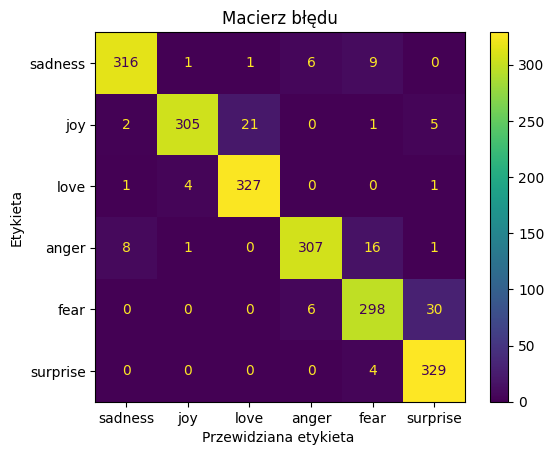

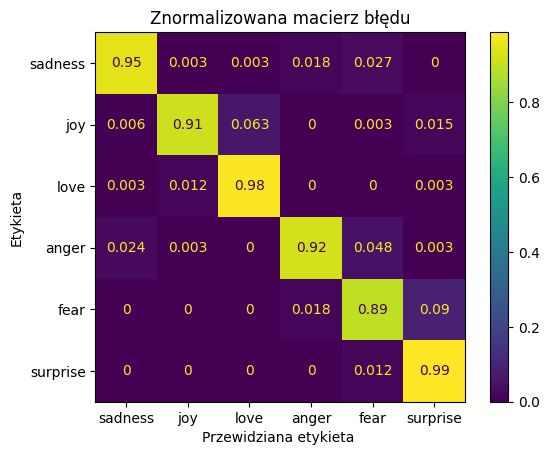

              precision    recall  f1-score   support

     sadness       0.97      0.95      0.96       333
         joy       0.98      0.91      0.95       334
        love       0.94      0.98      0.96       333
       anger       0.96      0.92      0.94       333
        fear       0.91      0.89      0.90       334
    surprise       0.90      0.99      0.94       333

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Model: Distil Bert
Vector input: Bert vectorizer
trainning time: 742.14213s
Dokładność (accuracy)  = 0.941
F1 Score (Micro) = 0.941
F1 Score (Macro) = 0.9409368596130882


In [ ]:

preds_output = trainer.predict(tokenized_bert_data["test"])
create_raport("Distil Bert",tokenized_bert_data["test"]["label"],normalize(preds_output.predictions,"max").argmax(axis=1),training_duration,"Bert vectorizer")